# Abundance zeropoint analysis

## Author(s): Sven Buder (SB, WG4)

### History:
180926 SB Created

In [192]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import collections
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from astropy.table import Table
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

# Sun (reference: Asplund et al. 2009)

In [193]:
sun = collections.OrderedDict()

sun['teff'] = [5772., 0.00] # Prsa et al., 2016, AJ, 152, 41
sun['logg'] = [4.44, 0.00] # Prsa et al., 2016, AJ, 152, 41
sun['fe_h'] = [0.00, 0.00]
sun['fe_h_atmo'] = [0.00, 0.00]
sun['vmic'] = [1.06 , 0.00] # GBS
sun['vbroad'] = [np.sqrt(4.00**2. + 1.6**2.),0.00] # GBS
sun['mass'] = [1.00 , 0.00] # by definition
sun['lbol'] = [1.00 , 0.00] # by definition
sun['age']  = [4.57 , 0.11] # Bonanno et al., 2002, A&A, 390, 1115
sun['alpha_fe']  = [0.00 , 0.00]

# Asplund+2009 Z, A_X, e_A_X
# sun["A_Li"] = [1.05, 0.10,  3]
# sun["A_C"]  = [8.43, 0.05,  6]
# sun["A_O"]  = [8.69, 0.05,  8]
# sun["A_Na"] = [6.24, 0.04, 11]
# sun["A_Mg"] = [7.60, 0.04, 12]
# sun["A_Al"] = [6.45, 0.03, 13]
# sun["A_Si"] = [7.51, 0.03, 14]
# sun["A_K"]  = [5.03, 0.09, 19]
# sun["A_Ca"] = [6.34, 0.04, 20]
# sun["A_Sc"] = [3.15, 0.04, 21]
# sun["A_Ti"] = [4.95, 0.05, 22]
# sun["A_V"]  = [3.93, 0.08, 23]
# sun["A_Cr"] = [5.64, 0.04, 24]
# sun["A_Mn"] = [5.43, 0.04, 25]
# sun["A_Fe"] = [7.50, 0.04, 26]
# sun["A_Co"] = [4.99, 0.07, 27]
# sun["A_Ni"] = [6.22, 0.04, 28]
# sun["A_Cu"] = [4.19, 0.04, 29]
# sun["A_Zn"] = [4.56, 0.05, 30]
# sun["A_Rb"] = [2.52, 0.10, 37]
# sun["A_Sr"] = [2.87, 0.07, 38]
# sun["A_Y"]  = [2.21, 0.05, 39]
# sun["A_Zr"] = [2.58, 0.04, 40]
# sun["A_Mo"] = [1.88, 0.08, 42]
# sun["A_Ru"] = [1.75, 0.08, 44]
# sun["A_Ba"] = [2.18, 0.09, 56]
# sun["A_La"] = [1.10, 0.04, 57]
# sun["A_Ce"] = [1.58, 0.04, 58]
# sun["A_Nd"] = [1.42, 0.04, 60]
# sun["A_Sm"] = [0.96, 0.04, 62]
# sun["A_Eu"] = [0.52, 0.04, 63]

# Grevesse
sun["A_Li"] = [1.05, 0.00,  3]
sun["A_C"]  = [8.39, 0.00,  6]
sun["A_C6588"]  = [8.39, 0.00,  6]
sun["A_O"]  = [8.66, 0.00,  8]
sun["A_O7772"]  = [8.66, 0.00,  8]
sun["A_O7774"]  = [8.66, 0.00,  8]
sun["A_O7775"]  = [8.66, 0.00,  8]
sun["A_Na"]     = [6.17, 0.00, 11]
sun["A_Na4752"] = [6.17, 0.00, 11]
sun["A_Na5683"] = [6.17, 0.00, 11]
sun["A_Na5688"] = [6.17, 0.00, 11]
sun["A_Mg"]     = [7.53, 0.00, 12]
sun["A_Mg4730"] = [7.53, 0.00, 12]
sun["A_Mg5711"] = [7.53, 0.00, 12]
sun["A_Mg7692"] = [7.53, 0.00, 12]
sun["A_Al"]     = [6.37, 0.00, 13]
sun["A_Al6696"] = [6.37, 0.00, 13]
sun["A_Al6699"] = [6.37, 0.00, 13]
sun["A_Al7835"] = [6.37, 0.00, 13]
sun["A_Al7836"] = [6.37, 0.00, 13]
sun["A_Si"] = [7.51, 0.00, 14]
sun["A_Si5666"] = [7.51, 0.00, 14]
sun["A_Si5684"] = [7.51, 0.00, 14]
sun["A_Si5690"] = [7.51, 0.00, 14]
sun["A_Si5701"] = [7.51, 0.00, 14]
sun["A_Si5772"] = [7.51, 0.00, 14]
sun["A_Si5793"] = [7.51, 0.00, 14]
sun["A_Si6722"] = [7.51, 0.00, 14]
sun["A_Si7680"] = [7.51, 0.00, 14]
sun["A_K"]  = [5.08, 0.00, 19]
sun["A_K5802"]  = [5.08, 0.00, 19]
sun["A_K7699"]  = [5.08, 0.00, 19]
sun["A_Ca"] = [6.31, 0.00, 20]
sun["A_Ca5857"] = [6.31, 0.00, 20]
sun["A_Ca5868"] = [6.31, 0.00, 20]
sun["A_Ca6494"] = [6.31, 0.00, 20]
sun["A_Ca6500"] = [6.31, 0.00, 20]
sun["A_Ca6509"] = [6.31, 0.00, 20]
sun["A_Sc"] = [3.17, 0.00, 21]
sun["A_Sc4744"] = [3.17, 0.00, 21]
sun["A_Sc4753"] = [3.17, 0.00, 21]
sun["A_Sc5672"] = [3.17, 0.00, 21]
sun["A_Sc5687"] = [3.17, 0.00, 21]
sun["A_Sc5717"] = [3.17, 0.00, 21]
sun["A_Sc5724"] = [3.17, 0.00, 21]
sun["A_Sc5658"] = [3.17, 0.00, 21]
sun["A_Sc5667"] = [3.17, 0.00, 21]
sun["A_Sc5684"] = [3.17, 0.00, 21]
sun["A_Sc6605"] = [3.17, 0.00, 21]
sun["A_Ti"] = [4.90, 0.00, 22]
sun["A_Ti4758"] = [4.90, 0.00, 22]
sun["A_Ti4759"] = [4.90, 0.00, 22]
sun["A_Ti4778"] = [4.90, 0.00, 22]
sun["A_Ti4782"] = [4.90, 0.00, 22]
sun["A_Ti4798"] = [4.90, 0.00, 22]
sun["A_Ti4802"] = [4.90, 0.00, 22]
sun["A_Ti4820"] = [4.90, 0.00, 22]
sun["A_Ti5689"] = [4.90, 0.00, 22]
sun["A_Ti5716"] = [4.90, 0.00, 22]
sun["A_Ti5720"] = [4.90, 0.00, 22]
sun["A_Ti5739"] = [4.90, 0.00, 22]
sun["A_Ti5866"] = [4.90, 0.00, 22]
sun["A_Ti6599"] = [4.90, 0.00, 22]
sun["A_Ti6717"] = [4.90, 0.00, 22]
sun["A_Ti7853"] = [4.90, 0.00, 22]
sun["A_Ti4720"] = [4.90, 0.00, 22]
sun["A_Ti4765"] = [4.90, 0.00, 22]
sun["A_Ti4799"] = [4.90, 0.00, 22]
sun["A_Ti4849"] = [4.90, 0.00, 22]
sun["A_Ti4866"] = [4.90, 0.00, 22]
sun["A_Ti4874"] = [4.90, 0.00, 22]
sun["A_V"]  = [4.00, 0.00, 23]
sun["A_V4747"]  = [4.00, 0.00, 23]
sun["A_V4784"]  = [4.00, 0.00, 23]
sun["A_V4797"]  = [4.00, 0.00, 23]
sun["A_V4832"]  = [4.00, 0.00, 23]
sun["A_Cr"] = [5.64, 0.00, 24]
sun["A_Cr4775"] = [5.64, 0.00, 24]
sun["A_Cr4789"] = [5.64, 0.00, 24]
sun["A_Cr4801"] = [5.64, 0.00, 24]
sun["A_Cr5702"] = [5.64, 0.00, 24]
sun["A_Cr5720"] = [5.64, 0.00, 24]
sun["A_Cr5788"] = [5.64, 0.00, 24]
sun["A_Cr5845"] = [5.64, 0.00, 24]
sun["A_Cr6630"] = [5.64, 0.00, 24]
sun["A_Cr4848"] = [5.64, 0.00, 24]
sun["A_Mn"] = [5.39, 0.00, 25]
sun["A_Mn4739"] = [5.39, 0.00, 25]
sun["A_Mn4762"] = [5.39, 0.00, 25]
sun["A_Mn4766"] = [5.39, 0.00, 25]
sun["A_Mn4783"] = [5.39, 0.00, 25]
sun["A_Fe"] = [7.45, 0.00, 26]
sun["A_Fe4789"] = [7.45, 0.00, 26]
sun["A_Fe4793"] = [7.45, 0.00, 26]
sun["A_Fe4794"] = [7.45, 0.00, 26]
sun["A_Fe4803"] = [7.45, 0.00, 26]
sun["A_Fe4808"] = [7.45, 0.00, 26]
sun["A_Fe4876"] = [7.45, 0.00, 26]
sun["A_Fe4890"] = [7.45, 0.00, 26]
sun["A_Fe4891"] = [7.45, 0.00, 26]
sun["A_Fe5651"] = [7.45, 0.00, 26]
sun["A_Fe5652"] = [7.45, 0.00, 26]
sun["A_Fe5661"] = [7.45, 0.00, 26]
sun["A_Fe5663"] = [7.45, 0.00, 26]
sun["A_Fe5679"] = [7.45, 0.00, 26]
sun["A_Fe5680"] = [7.45, 0.00, 26]
sun["A_Fe5696"] = [7.45, 0.00, 26]
sun["A_Fe5702"] = [7.45, 0.00, 26]
sun["A_Fe5705"] = [7.45, 0.00, 26]
sun["A_Fe5731"] = [7.45, 0.00, 26]
sun["A_Fe5732"] = [7.45, 0.00, 26]
sun["A_Fe5742"] = [7.45, 0.00, 26]
sun["A_Fe5775"] = [7.45, 0.00, 26]
sun["A_Fe5778"] = [7.45, 0.00, 26]
sun["A_Fe5807"] = [7.45, 0.00, 26]
sun["A_Fe5809"] = [7.45, 0.00, 26]
sun["A_Fe5812"] = [7.45, 0.00, 26]
sun["A_Fe5815"] = [7.45, 0.00, 26]
sun["A_Fe5850"] = [7.45, 0.00, 26]
sun["A_Fe5853"] = [7.45, 0.00, 26]
sun["A_Fe5855"] = [7.45, 0.00, 26]
sun["A_Fe5859"] = [7.45, 0.00, 26]
sun["A_Fe6482"] = [7.45, 0.00, 26]
sun["A_Fe6495"] = [7.45, 0.00, 26]
sun["A_Fe6499"] = [7.45, 0.00, 26]
sun["A_Fe6518"] = [7.45, 0.00, 26]
sun["A_Fe6546"] = [7.45, 0.00, 26]
sun["A_Fe6593"] = [7.45, 0.00, 26]
sun["A_Fe6594"] = [7.45, 0.00, 26]
sun["A_Fe6598"] = [7.45, 0.00, 26]
sun["A_Fe6609"] = [7.45, 0.00, 26]
sun["A_Fe6628"] = [7.45, 0.00, 26]
sun["A_Fe6648"] = [7.45, 0.00, 26]
sun["A_Fe6678"] = [7.45, 0.00, 26]
sun["A_Fe6699"] = [7.45, 0.00, 26]
sun["A_Fe6704"] = [7.45, 0.00, 26]
sun["A_Fe6714"] = [7.45, 0.00, 26]
sun["A_Fe6725"] = [7.45, 0.00, 26]
sun["A_Fe6733"] = [7.45, 0.00, 26]
sun["A_Fe7710"] = [7.45, 0.00, 26]
sun["A_Fe7723"] = [7.45, 0.00, 26]
sun["A_Fe7748"] = [7.45, 0.00, 26]
sun["A_Fe4720"] = [7.45, 0.00, 26]
sun["A_Fe4731"] = [7.45, 0.00, 26]
sun["A_Fe4833"] = [7.45, 0.00, 26]
sun["A_Fe6516"] = [7.45, 0.00, 26]
sun["A_Fe7712"] = [7.45, 0.00, 26]
sun["A_Co"] = [4.92, 0.00, 27]
sun["A_Co5647"] = [4.92, 0.00, 27]
sun["A_Co6632"] = [4.92, 0.00, 27]
sun["A_Co7713"] = [4.92, 0.00, 27]
sun["A_Co7838"] = [4.92, 0.00, 27]
sun["A_Ni"] = [6.23, 0.00, 28]
sun["A_Ni5847"] = [6.23, 0.00, 28]
sun["A_Ni6586"] = [6.23, 0.00, 28]
sun["A_Cu"] = [4.21, 0.00, 29]
sun["A_Cu5700"] = [4.21, 0.00, 29]
sun["A_Cu5782"] = [4.21, 0.00, 29]
sun["A_Zn"] = [4.60, 0.00, 30]
sun["A_Zn4722"] = [4.60, 0.00, 30]
sun["A_Zn4811"] = [4.60, 0.00, 30]
sun["A_Rb"] = [2.60, 0.00, 37]
sun["A_Rb7800"] = [2.60, 0.00, 37]
sun["A_Sr"] = [2.92, 0.00, 38]
sun["A_Sr6550"] = [2.92, 0.00, 38]
sun["A_Y"]  = [2.21, 0.00, 39]
sun["A_Y4855"]  = [2.21, 0.00, 39]
sun["A_Y4884"]  = [2.21, 0.00, 39]
sun["A_Y5663"]  = [2.21, 0.00, 39]
sun["A_Y5729"]  = [2.21, 0.00, 39]
sun["A_Zr"] = [2.58, 0.00, 40]
sun["A_Zr4739"] = [2.58, 0.00, 40]
sun["A_Zr4772"] = [2.58, 0.00, 40]
sun["A_Zr4806"] = [2.58, 0.00, 40]
sun["A_Zr4828"] = [2.58, 0.00, 40]
sun["A_Mo"] = [1.92, 0.00, 42]
sun["A_Mo5751"] = [1.92, 0.00, 42]
sun["A_Mo5858"] = [1.92, 0.00, 42]
sun["A_Ru"] = [1.84, 0.00, 44]
sun["A_Ru4869"] = [1.84, 0.00, 44]
sun["A_Ba"] = [2.17, 0.00, 56]
sun["A_Ba5854"] = [2.17, 0.00, 56]
sun["A_Ba6497"] = [2.17, 0.00, 56]
sun["A_La"] = [1.13, 0.00, 57]
sun["A_La4716"] = [1.13, 0.00, 57]
sun["A_La4749"] = [1.13, 0.00, 57]
sun["A_La4804"] = [1.13, 0.00, 57]
sun["A_La5806"] = [1.13, 0.00, 57]
sun["A_Ce"] = [1.70, 0.00, 58]
sun["A_Ce4774"] = [1.70, 0.00, 58]
sun["A_Nd"] = [1.45, 0.00, 60]
sun["A_Nd4811"] = [1.45, 0.00, 60]
sun["A_Nd5741"] = [1.45, 0.00, 60]
sun["A_Nd5770"] = [1.45, 0.00, 60]
sun["A_Nd5812"] = [1.45, 0.00, 60]
sun["A_Nd5842"] = [1.45, 0.00, 60]
sun["A_Sm"] = [1.00, 0.00, 62]
sun["A_Sm4837"] = [1.00, 0.00, 62]
sun["A_Sm4854"] = [1.00, 0.00, 62]
sun["A_Eu"] = [0.52, 0.00, 63]
sun["A_Eu5819"] = [0.52, 0.00, 63]
sun["A_Eu6645"] = [0.52, 0.00, 63]

# Arcturus (reference: internal APOGEE values, Ramirez & Allende Prieto 2011)

In [194]:
arcturus = collections.OrderedDict()

arcturus['teff'] = [4286, 35] # Heiter et al., 2005, A&A, 582, 49
arcturus['logg'] = [1.60, 0.20] # Heiter et al., 2005, A&A, 582, 49
arcturus['fe_h'] = [-0.52, 0.08] # Heiter et al., 2005, A&A, 582, 49
arcturus['fe_h_atmo'] = [-0.52, 0.08] # Heiter et al., 2005, A&A, 582, 49
arcturus['vmic'] = [1.25 , 0.00] 
arcturus['vbroad'] = [np.sqrt(5.07**2. + 3.8**2.), 0.00] 
arcturus['mass'] = [1.08 , 0.06] # Ramirez & Allende Prieto, 2011, ApJ, 743, 135
arcturus['lbol'] = [197.2, 2.2] # Heiter et al., 2005, A&A, 582, 49
arcturus['age']  = [7.1, 1.5] # Ramirez & Allende Prieto, 2011, ApJ, 743, 135
arcturus['alpha_fe']  = [0.20 , 0.00]

# Values from internal APOGEE communication, errors assumed to be 0.03!
arcturus["A_Li"] = [0.53, 0.03,  3]
arcturus["A_C"]  = [8.03, 0.03,  6]
arcturus["A_C6588"]  = [8.03, 0.03,  6]
arcturus["A_O"]  = [8.63, 0.03,  8]
arcturus["A_O7772"]  = [8.63, 0.03,  8]
arcturus["A_O7774"]  = [8.63, 0.03,  8]
arcturus["A_O7775"]  = [8.63, 0.03,  8]
arcturus["A_Na"] = [5.76, 0.03, 11]
arcturus["A_Na4752"] = [5.77, 0.01, 11] # Ramirez
arcturus["A_Na5683"] = [5.76, 0.03, 11]
arcturus["A_Na5688"] = [5.76, 0.03, 11]
arcturus["A_Mg"] = [7.55, 0.03, 12] # Ramirez combined
arcturus["A_Mg4730"] = [7.56, 0.03, 12] # Ramirez
arcturus["A_Mg5711"] = [7.55, 0.03, 12] # Ramirez
arcturus["A_Mg7692"] = [7.55, 0.03, 12] # Ramirez combined
arcturus["A_Al"] = [6.19, 0.03, 13]
arcturus["A_Al6696"] = [6.30, 0.02, 13] # Ramirez
arcturus["A_Al6699"] = [6.17, 0.02, 13] # Ramirez
arcturus["A_Al7835"] = [6.30, 0.02, 13] # Ramirez
arcturus["A_Al7836"] = [6.25, 0.02, 13] # Ramirez
arcturus["A_Si"] = [7.32, 0.03, 14]
arcturus["A_Si5666"] = [7.32, 0.03, 14]
arcturus["A_Si5684"] = [7.24, 0.02, 14] # Ramirez
arcturus["A_Si5690"] = [7.30, 0.02, 14] # Ramirez
arcturus["A_Si5701"] = [7.23, 0.02, 14] # Ramirez
arcturus["A_Si5772"] = [7.37, 0.02, 14] # Ramirez
arcturus["A_Si5793"] = [7.34, 0.02, 14] # Ramirez
arcturus["A_Si6722"] = [7.32, 0.03, 14]
arcturus["A_Si7680"] = [7.32, 0.03, 14]
arcturus["A_K"]  = [4.99, 0.04, 19] # Ramire
arcturus["A_K5802"]  = [4.76, 0.03, 19]
arcturus["A_K7699"]  = [4.76, 0.03, 19]
arcturus["A_Ca"] = [5.90, 0.03, 20]
arcturus["A_Ca5857"] = [5.90, 0.03, 20]
arcturus["A_Ca5868"] = [5.92, 0.02, 20] # Ramirez
arcturus["A_Ca6494"] = [5.90, 0.03, 20]
arcturus["A_Ca6500"] = [5.90, 0.03, 20]
arcturus["A_Ca6509"] = [5.90, 0.03, 20]
arcturus["A_Sc"] = [2.80, 0.03, 21]
arcturus["A_Sc4744"] = [2.69, 0.03, 21] # Ramirez
arcturus["A_Sc4753"] = [2.80, 0.03, 21]
arcturus["A_Sc5672"] = [3.04, 0.04, 21] # Ramirez
arcturus["A_Sc5687"] = [2.80, 0.03, 21]
arcturus["A_Sc5717"] = [2.80, 0.03, 21]
arcturus["A_Sc5724"] = [2.80, 0.03, 21]
arcturus["A_Sc5658"] = [2.80, 0.03, 21]
arcturus["A_Sc5667"] = [2.80, 0.03, 21]
arcturus["A_Sc5684"] = [2.80, 0.03, 21]
arcturus["A_Sc6605"] = [2.82, 0.03, 21] # Ramirez
arcturus["A_Ti"] = [4.65, 0.03, 22]
arcturus["A_Ti4758"] = [4.65, 0.03, 22]
arcturus["A_Ti4759"] = [4.65, 0.03, 22]
arcturus["A_Ti4778"] = [4.65, 0.03, 22]
arcturus["A_Ti4782"] = [4.65, 0.03, 22]
arcturus["A_Ti4798"] = [4.65, 0.03, 22]
arcturus["A_Ti4802"] = [4.65, 0.03, 22]
arcturus["A_Ti4820"] = [4.65, 0.03, 22]
arcturus["A_Ti5689"] = [4.65, 0.03, 22]
arcturus["A_Ti5716"] = [4.68, 0.02, 22] # Ramirez
arcturus["A_Ti5720"] = [4.65, 0.03, 22]
arcturus["A_Ti5739"] = [4.65, 0.03, 22]
arcturus["A_Ti5866"] = [4.65, 0.03, 22]
arcturus["A_Ti6599"] = [4.73, 0.03, 22] # Ramirez
arcturus["A_Ti6717"] = [4.65, 0.03, 22]
arcturus["A_Ti7853"] = [4.65, 0.03, 22]
arcturus["A_Ti4720"] = [4.65, 0.03, 22]
arcturus["A_Ti4765"] = [4.65, 0.03, 22]
arcturus["A_Ti4799"] = [4.65, 0.03, 22]
arcturus["A_Ti4849"] = [4.65, 0.03, 22]
arcturus["A_Ti4866"] = [4.65, 0.03, 22]
arcturus["A_Ti4874"] = [4.65, 0.03, 22]
arcturus["A_V"]  = [3.54, 0.03, 23]
arcturus["A_V4747"]  = [3.54, 0.03, 23]
arcturus["A_V4784"]  = [3.54, 0.03, 23]
arcturus["A_V4797"]  = [3.54, 0.03, 23]
arcturus["A_V4832"]  = [3.54, 0.03, 23]
arcturus["A_Cr"] = [5.07, 0.03, 24]
arcturus["A_Cr4775"] = [5.07, 0.03, 24]
arcturus["A_Cr4789"] = [5.07, 0.03, 24]
arcturus["A_Cr4801"] = [4.95, 0.03, 24] # Ramirez
arcturus["A_Cr5702"] = [5.07, 0.03, 24]
arcturus["A_Cr5720"] = [5.07, 0.03, 24]
arcturus["A_Cr5788"] = [5.07, 0.03, 24]
arcturus["A_Cr5845"] = [5.07, 0.03, 24]
arcturus["A_Cr6630"] = [5.07, 0.03, 24]
arcturus["A_Cr4848"] = [5.07, 0.03, 24]
arcturus["A_Mn"] = [4.66, 0.03, 25]
arcturus["A_Mn4739"] = [4.83, 0.04, 25] # Ramirez
arcturus["A_Mn4762"] = [4.66, 0.03, 25]
arcturus["A_Mn4766"] = [4.66, 0.03, 25]
arcturus["A_Mn4783"] = [4.66, 0.03, 25]
arcturus["A_Fe"] = [6.93, 0.03, 26]
arcturus["A_Fe4789"] = [6.93, 0.03, 26]
arcturus["A_Fe4793"] = [6.93, 0.03, 26]
arcturus["A_Fe4794"] = [6.93, 0.03, 26]
arcturus["A_Fe4803"] = [6.93, 0.03, 26]
arcturus["A_Fe4808"] = [6.93, 0.03, 26]
arcturus["A_Fe4876"] = [6.93, 0.03, 26]
arcturus["A_Fe4890"] = [6.93, 0.03, 26]
arcturus["A_Fe4891"] = [6.93, 0.03, 26]
arcturus["A_Fe5651"] = [6.93, 0.03, 26]
arcturus["A_Fe5652"] = [6.93, 0.03, 26]
arcturus["A_Fe5661"] = [6.93, 0.03, 26]
arcturus["A_Fe5663"] = [6.93, 0.03, 26]
arcturus["A_Fe5679"] = [6.93, 0.03, 26]
arcturus["A_Fe5680"] = [6.93, 0.03, 26]
arcturus["A_Fe5696"] = [6.93, 0.03, 26]
arcturus["A_Fe5702"] = [6.93, 0.03, 26]
arcturus["A_Fe5705"] = [6.93, 0.03, 26]
arcturus["A_Fe5731"] = [6.93, 0.03, 26]
arcturus["A_Fe5732"] = [6.93, 0.03, 26]
arcturus["A_Fe5742"] = [6.93, 0.03, 26]
arcturus["A_Fe5775"] = [6.93, 0.03, 26]
arcturus["A_Fe5778"] = [6.93, 0.03, 26]
arcturus["A_Fe5807"] = [6.93, 0.03, 26]
arcturus["A_Fe5809"] = [6.93, 0.03, 26]
arcturus["A_Fe5812"] = [6.93, 0.03, 26]
arcturus["A_Fe5815"] = [6.93, 0.03, 26]
arcturus["A_Fe5850"] = [6.93, 0.03, 26]
arcturus["A_Fe5853"] = [6.93, 0.03, 26]
arcturus["A_Fe5855"] = [6.93, 0.03, 26]
arcturus["A_Fe5859"] = [6.93, 0.03, 26]
arcturus["A_Fe6482"] = [6.93, 0.03, 26]
arcturus["A_Fe6495"] = [6.93, 0.03, 26]
arcturus["A_Fe6499"] = [6.93, 0.03, 26]
arcturus["A_Fe6518"] = [6.93, 0.03, 26]
arcturus["A_Fe6546"] = [6.93, 0.03, 26]
arcturus["A_Fe6593"] = [6.93, 0.03, 26]
arcturus["A_Fe6594"] = [6.93, 0.03, 26]
arcturus["A_Fe6598"] = [6.93, 0.03, 26]
arcturus["A_Fe6609"] = [6.93, 0.03, 26]
arcturus["A_Fe6628"] = [6.93, 0.03, 26]
arcturus["A_Fe6648"] = [6.93, 0.03, 26]
arcturus["A_Fe6678"] = [6.93, 0.03, 26]
arcturus["A_Fe6699"] = [6.93, 0.03, 26]
arcturus["A_Fe6704"] = [6.93, 0.03, 26]
arcturus["A_Fe6714"] = [6.93, 0.03, 26]
arcturus["A_Fe6725"] = [6.93, 0.03, 26]
arcturus["A_Fe6733"] = [6.93, 0.03, 26]
arcturus["A_Fe7710"] = [6.93, 0.03, 26]
arcturus["A_Fe7723"] = [6.93, 0.03, 26]
arcturus["A_Fe7748"] = [6.93, 0.03, 26]
arcturus["A_Fe4720"] = [6.93, 0.03, 26]
arcturus["A_Fe4731"] = [6.93, 0.03, 26]
arcturus["A_Fe4833"] = [6.93, 0.03, 26]
arcturus["A_Fe6516"] = [6.93, 0.03, 26]
arcturus["A_Fe7712"] = [6.93, 0.03, 26]
arcturus["A_Co"] = [4.49, 0.03, 27]
arcturus["A_Co5647"] = [4.67, 0.03, 27] # Ramirez
arcturus["A_Co6632"] = [4.49, 0.03, 27]
arcturus["A_Co7713"] = [4.49, 0.03, 27]
arcturus["A_Co7838"] = [4.49, 0.03, 27]
arcturus["A_Ni"] = [5.77, 0.03, 28]
arcturus["A_Ni5847"] = [5.77, 0.03, 28]
arcturus["A_Ni6586"] = [5.77, 0.03, 28]
arcturus["A_Cu"] = [3.71, 0.03, 29]
arcturus["A_Cu5700"] = [3.71, 0.03, 29]
arcturus["A_Cu5782"] = [3.71, 0.03, 29]
arcturus["A_Zn"] = [4.08, 0.03, 30]
arcturus["A_Zn4722"] = [4.08, 0.03, 30]
arcturus["A_Zn4811"] = [4.15, 0.04, 30] # Ramirez
arcturus["A_Rb"] = [2.08, 0.03, 37]
arcturus["A_Rb7800"] = [2.08, 0.03, 37]
arcturus["A_Sr"] = [2.40, 0.03, 38]
arcturus["A_Sr6550"] = [2.40, 0.03, 38]
arcturus["A_Y"]  = [1.69, 0.03, 39]
arcturus["A_Y4855"]  = [1.69, 0.03, 39]
arcturus["A_Y4884"]  = [1.69, 0.03, 39]
arcturus["A_Y5663"]  = [1.69, 0.03, 39]
arcturus["A_Y5729"]  = [1.69, 0.03, 39]
arcturus["A_Zr"] = [2.06, 0.03, 40]
arcturus["A_Zr4739"] = [2.06, 0.03, 40]
arcturus["A_Zr4772"] = [2.06, 0.03, 40]
arcturus["A_Zr4806"] = [2.06, 0.03, 40]
arcturus["A_Zr4828"] = [2.06, 0.03, 40]
arcturus["A_Mo"] = [1.40, 0.03, 42]
arcturus["A_Mo5751"] = [1.40, 0.03, 42]
arcturus["A_Mo5858"] = [1.40, 0.03, 42]
arcturus["A_Ru"] = [1.32, 0.03, 44]
arcturus["A_Ru4869"] = [1.32, 0.03, 44]
arcturus["A_Ba"] = [1.65, 0.03, 56]
arcturus["A_Ba5854"] = [1.65, 0.03, 56]
arcturus["A_Ba6497"] = [1.65, 0.03, 56]
arcturus["A_La"] = [0.61, 0.03, 57]
arcturus["A_La4716"] = [0.61, 0.03, 57]
arcturus["A_La4749"] = [0.61, 0.03, 57]
arcturus["A_La4804"] = [0.61, 0.03, 57]
arcturus["A_La5806"] = [0.61, 0.03, 57]
arcturus["A_Ce"] = [0.99, 0.03, 58]
arcturus["A_Ce4774"] = [0.99, 0.03, 58]
arcturus["A_Nd"] = [0.94, 0.03, 60]
arcturus["A_Nd4811"] = [0.94, 0.03, 60]
arcturus["A_Nd5741"] = [0.94, 0.03, 60]
arcturus["A_Nd5770"] = [0.94, 0.03, 60]
arcturus["A_Nd5812"] = [0.94, 0.03, 60]
arcturus["A_Nd5842"] = [0.94, 0.03, 60]
arcturus["A_Sm"] = [0.48, 0.03, 62]
arcturus["A_Sm4837"] = [0.48, 0.03, 62]
arcturus["A_Sm4854"] = [0.48, 0.03, 62]
arcturus["A_Eu"] = [0.00, 0.03, 63]
arcturus["A_Eu5819"] = [0.00, 0.03, 63]
arcturus["A_Eu6645"] = [0.00, 0.03, 63]

# GALAH values

In [195]:
gbs_lbol     = pyfits.getdata('../gbs/data/GALAH_gbs_lbol.fits',1)
gbs_sun      = gbs_lbol[(gbs_lbol['sobject_id'] == 150405000901378)][0]
gbs_arcturus = gbs_lbol[(gbs_lbol['sobject_id'] == 150210005801171)][0]

In [196]:
galah_sun = collections.OrderedDict()

galah_sun['teff'] = [float('%.0f' % gbs_sun['TEFF']), float('%.0f' % gbs_sun['E_TEFF'])] 
galah_sun['logg'] = [float('%.2f' % gbs_sun['LOGG']), float(0.0)] 
galah_sun['fe_h'] = [float('%.2f' % gbs_sun['FEH']), float(0.0)] 
galah_sun['fe_h_atmo'] = [float('%.2f' % gbs_sun['FEH']), float(0.0)] 
galah_sun['vmic'] = [float('%.2f' % gbs_sun['VMIC']), float(0.0)] 
galah_sun['vbroad'] = [float('%.2f' % gbs_sun['VSINI']), float(0.0)] 
galah_sun['mass'] = [float('%.2f' % gbs_sun['MASS']), float(0.0)] 
galah_sun['lbol'] = [float('%.2f' % gbs_sun['LBOL']), float(0.0)] 
galah_sun['age']  = [float('%.2f' % gbs_sun['AGE']), float(0.0)] 
galah_sun['alpha_fe']  = [float('%.2f' % gbs_sun['ALPHA_FE']), float(0.0)] 
galah_sun['chi2_sp']  = [float('%.2f' % gbs_sun['CHI'][0]), float(0.0)]

# Z, A_X, e_A_X

for iterator, each_mode in enumerate(gbs_sun['MODE']):
    if (each_mode != 'Sp') & (len(each_mode) >=1):
        if (len(each_mode) <= 2):
            galah_sun["A_"+each_mode] = np.array([
                float('%.2f' % gbs_sun['A_ABUND'][iterator]), 
                float('%.2f' % gbs_sun['E_ABUND'][iterator])
            ])
        else:

            galah_sun["A_"+each_mode] = np.array([
                float('%.2f' % gbs_sun['A_ABUND'][iterator]), 
                float('%.2f' % gbs_sun['E_ABUND'][iterator])
            ])

#             if each_mode == 'K7699':
#                 galah_sun["A_K"] = np.array([
#                     float('%.2f' % gbs_sun['A_ABUND'][iterator]),
#                     float('%.2f' % gbs_sun['E_ABUND'][iterator])
#                 ])

#             if each_mode == 'Ca5862':
#                 galah_sun["A_Ca"] = np.array([
#                     float('%.2f' % gbs_sun['A_ABUND'][iterator]),
#                     float('%.2f' % gbs_sun['E_ABUND'][iterator])
#                 ])

#             if each_mode == 'Cu5782':
#                 galah_sun["A_Cu"] = np.array([
#                     float('%.2f' % gbs_sun['A_ABUND'][iterator]),
#                     float('%.2f' % gbs_sun['E_ABUND'][iterator])
#                 ])

#             if each_mode == 'Ba5854':
#                 galah_sun["A_Ba"] = np.array([
#                     float('%.2f' % np.nanmean([gbs_sun['A_ABUND'][iterator],gbs_sun['A_ABUND'][iterator+1]])), 
#                     float('%.2f' % np.nanmean([gbs_sun['E_ABUND'][iterator],gbs_sun['E_ABUND'][iterator+1]]))
#                 ])

In [198]:
galah_arcturus = collections.OrderedDict()

galah_arcturus['teff'] = ['%.0f' % gbs_arcturus['TEFF'], '%.0f' % gbs_arcturus['E_TEFF']] 
galah_arcturus['logg'] = ['%.2f' % gbs_arcturus['LOGG'], np.nan] 
galah_arcturus['fe_h'] = ['%.2f' % gbs_arcturus['FEH'], np.nan]
galah_arcturus['fe_h_atmo'] = ['%.2f' % gbs_arcturus['FEH'], np.nan]
galah_arcturus['vmic'] = ['%.2f' % gbs_arcturus['VMIC'], np.nan]
galah_arcturus['vbroad'] = ['%.2f' % gbs_arcturus['VSINI'], np.nan]
galah_arcturus['mass'] = ['%.2f' % gbs_arcturus['MASS'], np.nan] 
galah_arcturus['lbol'] = ['%.2f' % gbs_arcturus['LBOL'], np.nan] 
galah_arcturus['age']  = ['%.2f' % gbs_arcturus['AGE'], np.nan] 
galah_arcturus['chi2_sp']  = ['%.2f' % gbs_arcturus['CHI'][0], np.nan] 

# Z, A_X, e_A_X

for iterator, each_mode in enumerate(gbs_arcturus['MODE']):
    if (each_mode != 'Sp') & (len(each_mode) >=1):
        if (len(each_mode) <= 2):
            galah_arcturus["A_"+each_mode] = np.array([
                float('%.2f' % gbs_arcturus['A_ABUND'][iterator]), 
                float('%.2f' % gbs_arcturus['E_ABUND'][iterator])
            ])
        else:

            galah_arcturus["A_"+each_mode] = np.array([
                float('%.2f' % gbs_arcturus['A_ABUND'][iterator]), 
                float('%.2f' % gbs_arcturus['E_ABUND'][iterator])
            ])
#     else:
#         if each_mode == 'K7699':
#             galah_arcturus["A_K"] = np.array([
#                 '%.2f' % gbs_arcturus['A_ABUND'][iterator], 
#                 '%.2f' % gbs_arcturus['E_ABUND'][iterator]
#             ])
        
#         if each_mode == 'Ca5862':
#             galah_arcturus["A_Ca"] = np.array([
#                 '%.2f' % gbs_arcturus['A_ABUND'][iterator],
#                 '%.2f' % gbs_arcturus['E_ABUND'][iterator]
#             ])

#         if each_mode == 'Cu5782':
#             galah_arcturus["A_Cu"] = np.array([
#                 '%.2f' % gbs_arcturus['A_ABUND'][iterator],
#                 '%.2f' % gbs_arcturus['E_ABUND'][iterator]
#             ])
            
#         if each_mode == 'Ba5854':
#             galah_arcturus["A_Ba"] = np.array([
#                 '%.0f' % np.nanmean([gbs_arcturus['A_ABUND'][iterator],gbs_arcturus['A_ABUND'][iterator+1]]), 
#                 '%.0f' % np.nanmean([gbs_arcturus['E_ABUND'][iterator],gbs_arcturus['E_ABUND'][iterator+1]])
#             ])

In [200]:
for each_key in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age']:
    print(each_key,',',sun[each_key][0],'$\pm$',sun[each_key][1],',',galah_sun[each_key][0],'$\pm$',galah_sun[each_key][1])

teff , 5772.0 $\pm$ 0.0 , 5779.0 $\pm$ 104.0
logg , 4.44 $\pm$ 0.0 , 4.42 $\pm$ 0.0
fe_h , 0.0 $\pm$ 0.0 , 0.01 $\pm$ 0.0
fe_h_atmo , 0.0 $\pm$ 0.0 , 0.01 $\pm$ 0.0
vmic , 1.06 $\pm$ 0.0 , 1.16 $\pm$ 0.0
vbroad , 4.30813184571 $\pm$ 0.0 , 6.52 $\pm$ 0.0
mass , 1.0 $\pm$ 0.0 , 0.97 $\pm$ 0.0
lbol , 1.0 $\pm$ 0.0 , 1.01 $\pm$ 0.0
age , 4.57 $\pm$ 0.11 , 5.83 $\pm$ 0.0


In [201]:
for each_key in sun.keys():
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age']:
        try:
            print(each_key,',',sun[each_key][0],'$\pm$',sun[each_key][1],',',galah_sun[each_key][0],'$\pm$',galah_sun[each_key][1])
        except:
            print('skip '+each_key)

alpha_fe , 0.0 $\pm$ 0.0 , nan $\pm$ 0.0
A_Li , 1.05 $\pm$ 0.0 , 0.95 $\pm$ 0.38
skip A_C
A_C6588 , 8.39 $\pm$ 0.0 , 8.42 $\pm$ 0.02
skip A_O
A_O7772 , 8.66 $\pm$ 0.0 , 8.64 $\pm$ 0.02
A_O7774 , 8.66 $\pm$ 0.0 , 8.66 $\pm$ 0.05
A_O7775 , 8.66 $\pm$ 0.0 , 8.65 $\pm$ 0.06
skip A_Na
A_Na4752 , 6.17 $\pm$ 0.0 , nan $\pm$ nan
A_Na5683 , 6.17 $\pm$ 0.0 , 6.09 $\pm$ 0.01
A_Na5688 , 6.17 $\pm$ 0.0 , 6.09 $\pm$ 0.0
skip A_Mg
A_Mg4730 , 7.53 $\pm$ 0.0 , 7.6 $\pm$ 0.0
A_Mg5711 , 7.53 $\pm$ 0.0 , 7.78 $\pm$ 0.01
A_Mg7692 , 7.53 $\pm$ 0.0 , 7.51 $\pm$ 0.0
skip A_Al
A_Al6696 , 6.37 $\pm$ 0.0 , 6.45 $\pm$ 0.01
A_Al6699 , 6.37 $\pm$ 0.0 , 6.42 $\pm$ 0.01
A_Al7835 , 6.37 $\pm$ 0.0 , 6.41 $\pm$ 0.01
A_Al7836 , 6.37 $\pm$ 0.0 , 6.41 $\pm$ 0.01
skip A_Si
A_Si5666 , 7.51 $\pm$ 0.0 , 7.29 $\pm$ 0.01
A_Si5684 , 7.51 $\pm$ 0.0 , 7.33 $\pm$ 0.01
A_Si5690 , 7.51 $\pm$ 0.0 , 7.49 $\pm$ 0.01
A_Si5701 , 7.51 $\pm$ 0.0 , 7.46 $\pm$ 0.01
A_Si5772 , 7.51 $\pm$ 0.0 , 7.44 $\pm$ 0.01
A_Si5793 , 7.51 $\pm$ 0.0 , 7.49 $\

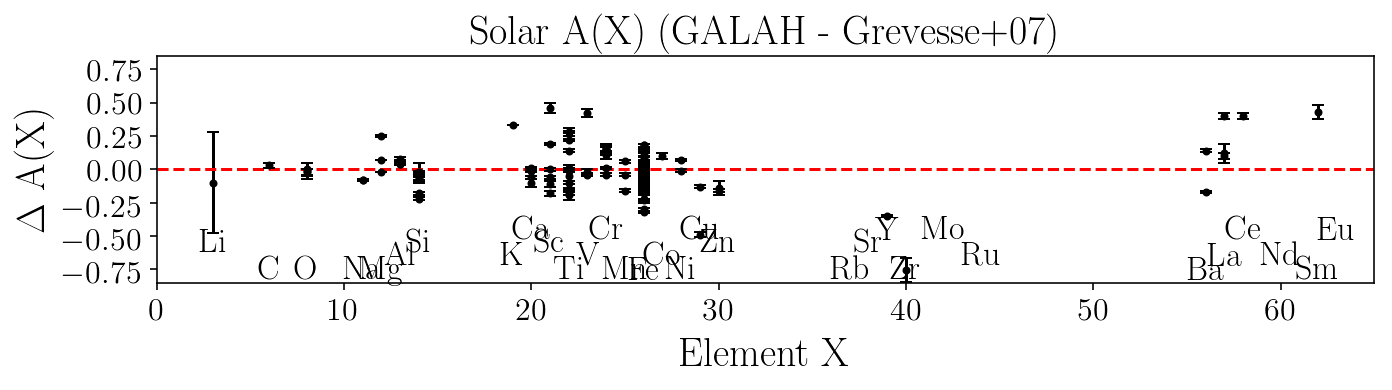

In [202]:
kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

f, (ax1) = plt.subplots(1, figsize=(10,3))

#ax1.set_title('Solar A(X) (GALAH - Asplund+09)', fontsize=20)
ax1.set_title('Solar A(X) (GALAH - Grevesse+07)', fontsize=20)
ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.851, 0.851)
ax1.set_xlim(0,65)
ax1.set_xlabel('Element X')
ax1.set_ylabel(r'$\Delta$ A(X)')
ax1.set_yticks([-0.75,-0.5, -0.25, 0.0, 0.25, 0.5,0.75])

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        try:
            ax1.errorbar(
                sun[each_key][2],
                float(galah_sun[each_key][0]) - float(sun[each_key][0]),
                yerr = np.sqrt(float(galah_sun[each_key][1])**2 + float(sun[each_key][1])**2),
                **kwargs_errorbar
                )
            if each_key != sun.keys()[-1]:
                if sun.keys()[it][2] != sun.keys()[it+1][2]:
                    if each_key[2:] in ['C6588','O7772','O7774','O7775','K5802','K7699','V4747','V4784','V4797','V4832','Y4855','Y4884','Y5663','Y5729']: 
                        ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:][:1],ha='center')
                    else:
                        ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:][:2],ha='center')
            else:
                ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:][:2],ha='center')
        except:
            pass
plt.tight_layout()
plt.savefig('figures/abundance_zeropoints_sun.png', dpi=300, bbox_inches='tight')

In [203]:
for each_key in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age']:
    print(each_key,',',arcturus[each_key][0],'$\pm$',arcturus[each_key][1],',',galah_arcturus[each_key][0],'$\pm$',galah_arcturus[each_key][1])

teff , 4286 $\pm$ 35 , 4289 $\pm$ 21
logg , 1.6 $\pm$ 0.2 , 1.65 $\pm$ nan
fe_h , -0.52 $\pm$ 0.08 , -0.53 $\pm$ nan
fe_h_atmo , -0.52 $\pm$ 0.08 , -0.53 $\pm$ nan
vmic , 1.25 $\pm$ 0.0 , 1.57 $\pm$ nan
vbroad , 6.33600031566 $\pm$ 0.0 , 6.20 $\pm$ nan
mass , 1.08 $\pm$ 0.06 , 0.96 $\pm$ nan
lbol , 197.2 $\pm$ 2.2 , 179.87 $\pm$ nan
age , 7.1 $\pm$ 1.5 , 9.42 $\pm$ nan


In [204]:
for each_key in arcturus.keys():
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        try:
            print(each_key,',',arcturus[each_key][0],'$\pm$',arcturus[each_key][1],',',galah_arcturus[each_key][0],'$\pm$',galah_arcturus[each_key][1])
        except:
            pass

A_Li , 0.53 $\pm$ 0.03 , -1.13 $\pm$ 0.45
A_C6588 , 8.03 $\pm$ 0.03 , nan $\pm$ nan
A_O7772 , 8.63 $\pm$ 0.03 , 8.71 $\pm$ 0.03
A_O7774 , 8.63 $\pm$ 0.03 , 8.85 $\pm$ 0.04
A_O7775 , 8.63 $\pm$ 0.03 , 8.75 $\pm$ 0.07
A_Na4752 , 5.77 $\pm$ 0.01 , 5.84 $\pm$ 0.0
A_Na5683 , 5.76 $\pm$ 0.03 , 5.7 $\pm$ 0.0
A_Na5688 , 5.76 $\pm$ 0.03 , 5.96 $\pm$ 0.0
A_Mg4730 , 7.56 $\pm$ 0.03 , 7.33 $\pm$ 0.01
A_Mg5711 , 7.55 $\pm$ 0.03 , 7.81 $\pm$ 0.02
A_Mg7692 , 7.55 $\pm$ 0.03 , 7.41 $\pm$ 0.01
A_Al6696 , 6.3 $\pm$ 0.02 , 6.28 $\pm$ 0.0
A_Al6699 , 6.17 $\pm$ 0.02 , 6.29 $\pm$ 0.0
A_Al7835 , 6.3 $\pm$ 0.02 , 6.23 $\pm$ 0.0
A_Al7836 , 6.25 $\pm$ 0.02 , 6.28 $\pm$ 0.0
A_Si5666 , 7.32 $\pm$ 0.03 , 6.76 $\pm$ 0.0
A_Si5684 , 7.24 $\pm$ 0.02 , 7.35 $\pm$ 0.0
A_Si5690 , 7.3 $\pm$ 0.02 , 7.15 $\pm$ 0.0
A_Si5701 , 7.23 $\pm$ 0.02 , 7.33 $\pm$ 0.0
A_Si5772 , 7.37 $\pm$ 0.02 , 7.27 $\pm$ 0.0
A_Si5793 , 7.34 $\pm$ 0.02 , 7.36 $\pm$ 0.0
A_Si6722 , 7.32 $\pm$ 0.03 , 7.36 $\pm$ 0.06
A_Si7680 , 7.32 $\pm$ 0.03 , 7.26 $\

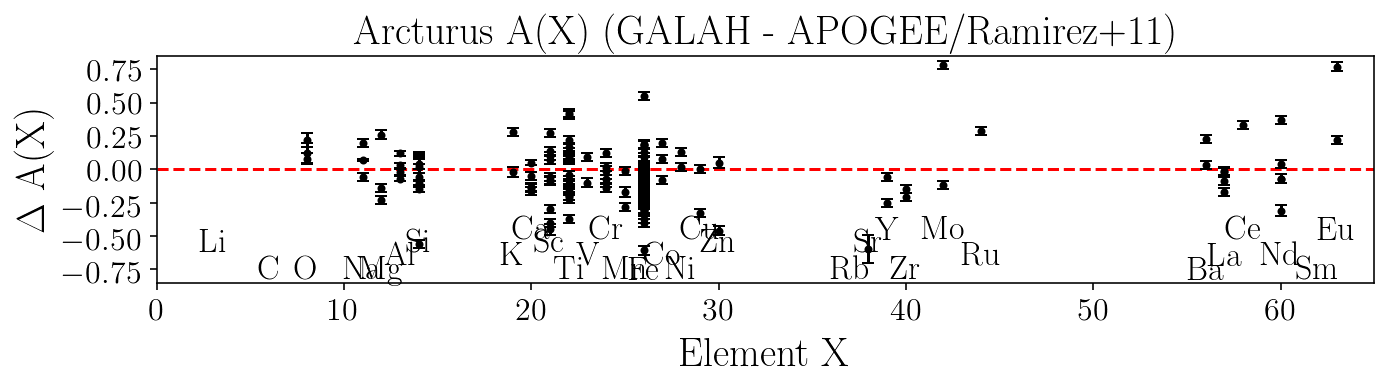

In [205]:
kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

f, (ax1) = plt.subplots(1, figsize=(10,3))
ax1.set_title('Arcturus A(X) (GALAH - APOGEE/Ramirez+11)', fontsize=20)

ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.851, 0.851)
ax1.set_xlim(0,65)
ax1.set_xlabel('Element X')
ax1.set_ylabel(r'$\Delta$ A(X)')
ax1.set_yticks([-0.75,-0.5, -0.25, 0.0, 0.25, 0.5,0.75])

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        try:
            ax1.errorbar(
                sun[each_key][2],
                float(galah_arcturus[each_key][0]) - float(arcturus[each_key][0]),
                yerr = np.sqrt(float(galah_arcturus[each_key][1])**2 + float(arcturus[each_key][1])**2),
                **kwargs_errorbar
                )
            if each_key != sun.keys()[-1]:
                if sun.keys()[it][2] != sun.keys()[it+1][2]:
                    if each_key[2:] in ['C6588','O7772','O7774','O7775','K5802','K7699','V4747','V4784','V4797','V4832','Y4855','Y4884','Y5663','Y5729']: 
                        ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:][:1],ha='center')
                    else:
                        ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:][:2],ha='center')
            else:
                ax1.text(arcturus[each_key][2], -.825 + it%4*0.1, each_key[2:][:2],ha='center')
        except:
            pass
plt.tight_layout()
plt.savefig('figures/abundance_zeropoints_arcturus.png', dpi=300, bbox_inches='tight')

In [206]:
print('Element','Sun','Arcturus')
for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        if (each_key == 'A_Li') | (len(each_key) > 4):
            print(each_key,float(galah_sun[each_key][0]) - float(sun[each_key][0]),float(galah_arcturus[each_key][0]) - float(arcturus[each_key][0]))

Element Sun Arcturus
A_Li -0.1 -1.66
A_C6588 0.03 nan
A_O7772 -0.02 0.08
A_O7774 0.0 0.22
A_O7775 -0.01 0.12
A_Na4752 nan 0.07
A_Na5683 -0.08 -0.06
A_Na5688 -0.08 0.2
A_Mg4730 0.07 -0.23
A_Mg5711 0.25 0.26
A_Mg7692 -0.02 -0.14
A_Al6696 0.08 -0.02
A_Al6699 0.05 0.12
A_Al7835 0.04 -0.07
A_Al7836 0.04 0.03
A_Si5666 -0.22 -0.56
A_Si5684 -0.18 0.11
A_Si5690 -0.02 -0.15
A_Si5701 -0.05 0.1
A_Si5772 -0.07 -0.1
A_Si5793 -0.02 0.02
A_Si6722 -0.06 0.04
A_Si7680 -0.05 -0.06
A_K5802 nan -0.02
A_K7699 0.33 0.28
A_Ca5857 -0.06 -0.05
A_Ca5868 0.0 0.05
A_Ca6494 0.01 -0.13
A_Ca6500 -0.01 -0.14
A_Ca6509 -0.1 -0.16
A_Sc4744 -0.18 0.07
A_Sc4753 nan -0.4
A_Sc5672 -0.11 -0.45
A_Sc5687 nan -0.3
A_Sc5717 0.46 -0.06
A_Sc5724 nan -0.08
A_Sc5658 0.0 0.1
A_Sc5667 0.19 0.27
A_Sc5684 nan 0.14
A_Sc6605 -0.06 -0.09
A_Ti4758 -0.15 -0.37
A_Ti4759 -0.18 -0.2
A_Ti4778 0.0 -0.08
A_Ti4782 0.14 0.11
A_Ti4798 nan -0.2
A_Ti4802 nan 0.08
A_Ti4820 -0.1 0.07
A_Ti5689 0.01 -0.22
A_Ti5716 nan -0.11
A_Ti5720 0.28 -0.04
A_Ti5739 -0.1

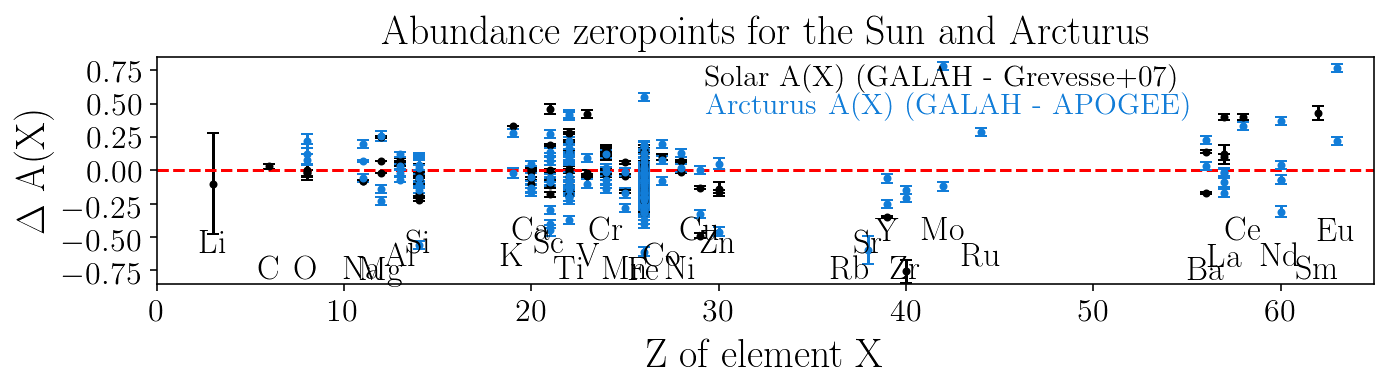

In [207]:
kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

f, (ax1) = plt.subplots(1, figsize=(10,3))

ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.651, 0.651)
ax1.set_xlim(0,65)

#ax1.text(0.45,0.975,'Solar A(X) (GALAH - Asplund+09)', fontsize=15, color='k',transform=ax1.transAxes,ha='left',va='top')
ax1.text(0.45,0.975,'Solar A(X) (GALAH - Grevesse+07)', fontsize=15, color='k',transform=ax1.transAxes,ha='left',va='top')
ax1.text(0.45,0.85,'Arcturus A(X) (GALAH - APOGEE)', fontsize=15, color=willi_blau,transform=ax1.transAxes,ha='left',va='top')

ax1.set_yticks([-0.75,-0.5, -0.25, 0.0, 0.25, 0.5,0.75])

kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        try:
            ax1.errorbar(
                sun[each_key][2],
                float(galah_sun[each_key][0]) - float(sun[each_key][0]),
                yerr = np.sqrt(float(galah_sun[each_key][1])**2 + float(sun[each_key][1])**2),
                **kwargs_errorbar
                )
            if each_key != sun.keys()[-1]:
                if sun.keys()[it][2] != sun.keys()[it+1][2]:
                    if each_key[2:] in ['C6588','O7772','O7774','O7775','K5802','K7699','V4747','V4784','V4797','V4832','Y4855','Y4884','Y5663','Y5729']: 
                        ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:][:1],ha='center')
                    else:
                        ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:][:2],ha='center')
            else:
                ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:][:2],ha='center')
        except:
            pass

kwargs_errorbar = dict(color = willi_blau, capsize=3, fmt='o', ms=3)

ax1.set_title('Abundance zeropoints for the Sun and Arcturus', fontsize=20)

ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.851, 0.851)
ax1.set_xlim(0,65)
ax1.set_xlabel('Z of element X')
ax1.set_ylabel(r'$\Delta$ A(X)')

for it, each_key in enumerate(arcturus.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        try:
            ax1.errorbar(
                sun[each_key][2],
                float(galah_arcturus[each_key][0]) - float(arcturus[each_key][0]),
                yerr = np.sqrt(float(galah_arcturus[each_key][1])**2 + float(arcturus[each_key][1])**2),
                **kwargs_errorbar
                )
        except:
            pass
            
plt.tight_layout()
plt.savefig('figures/abundance_zeropoints.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/abundance_zeropoints.pdf', dpi=300, bbox_inches='tight')

In [208]:
# #galah_sun['A_Co'][0:2] = np.array(sun["A_Co"][0:2])
# galah_sun['A_Co7713'][0:2] = np.array(sun["A_Co"][0:2])
# #galah_sun['A_Eu'][0:2] = np.array(sun["A_Eu"][0:2])
# galah_sun['A_Eu5819'][0:2] = np.array(sun["A_Eu"][0:2])
# galah_sun['A_Eu6645'][0:2] = np.array(sun["A_Eu"][0:2])
# galah_sun['A_K5802'][0:2] = np.array(sun["A_K"][0:2])
# #galah_sun['A_Mo'][0:2] = np.array(sun["A_Mo"][0:2])
# galah_sun['A_Na4752'][0:2] = np.array(sun["A_Na"][0:2])
# #galah_sun['A_Nd'][0:2] = np.array(sun["A_Nd"][0:2])
# galah_sun['A_Nd4811'][0:2] = np.array(sun["A_Nd"][0:2])
# #galah_sun['A_Rb'][0:2] = np.array(sun["A_Rb"][0:2])
# #galah_sun['A_Ru'][0:2] = np.array(sun["A_Ru"][0:2])
# #galah_sun['A_Sr'][0:2] = np.array(sun["A_Sr"][0:2])
# galah_sun['A_Y4855'][0:2] = np.array(sun["A_Y"][0:2])
# galah_sun['A_Y5663'][0:2] = np.array(sun["A_Y"][0:2])
# galah_sun['A_Y5729'][0:2] = np.array(sun["A_Y"][0:2])

In [210]:
for each in galah_arcturus.keys():
    if each[:2] == 'A_':
        if np.isnan(galah_arcturus[each][0]):
            galah_arcturus[each][0:2] = np.array(arcturus[each][0:2])

In [211]:
for each in galah_sun.keys():
    if np.isnan(galah_sun[each][0]):
        galah_sun[each][0:2] = np.array(sun[each][0:2])

In [212]:
sun_pandas = pandas.DataFrame(galah_sun,columns=galah_sun.keys())
sun_astropy = Table.from_pandas(sun_pandas)
sun_astropy.write('galahdr3_abundance_zeropoints.fits',overwrite=True)
sun_pandas

,teff,logg,fe_h,fe_h_atmo,vmic,vbroad,mass,lbol,age,alpha_fe,...,A_Ce4774,A_Nd4811,A_Nd5741,A_Nd5770,A_Nd5812,A_Nd5842,A_Sm4837,A_Sm4854,A_Eu5819,A_Eu6645
0,5779.0,4.42,0.01,0.01,1.16,6.52,0.97,1.01,5.83,0.0,...,2.10,1.45,1.45,1.45,1.45,1.45,1.0,1.43,0.52,0.52
1,104.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.02,0.00,0.00,0.00,0.00,0.00,0.0,0.05,0.00,0.00
